In [2]:
# Notebook cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

%matplotlib inline
sns.set_theme(style='whitegrid')

db_dir = Path("meltano-ingestion/db")  # or Path("db") depending on your project
csv_files = list(db_dir.glob("*.csv"))


In [6]:
# Create `prod_name_english` table
# This cell finds the product and category CSVs in `db_dir`, merges them
# to produce a two-column table: product_id, product_category_name_english
# Missing values in the English name will be filled with the string 'null'.

prod_candidates = sorted([p for p in db_dir.glob('*product*.csv')])
cat_candidates = sorted([p for p in db_dir.glob('*category*.csv')])

print('product candidates:', [p.name for p in prod_candidates])
print('category candidates:', [p.name for p in cat_candidates])

if not prod_candidates:
    raise FileNotFoundError(f'No product CSV found in {db_dir}')
if not cat_candidates:
    raise FileNotFoundError(f'No category CSV found in {db_dir}')

prod_path = prod_candidates[0]
cat_path = cat_candidates[0]

print('Using product file:', prod_path.name)
print('Using category file:', cat_path.name)

products = pd.read_csv(prod_path, low_memory=False)
categories = pd.read_csv(cat_path, low_memory=False)

print('products columns:', products.columns.tolist())
print('categories columns:', categories.columns.tolist())

# Auto-detect likely column names
prod_id_col = 'product_id' if 'product_id' in products.columns else next((c for c in products.columns if 'id' in c and 'product' in c), None)
prod_cat_col = next((c for c in products.columns if 'category' in c.lower()), None)
cat_key_col = next((c for c in categories.columns if 'category' in c.lower()), None)
cat_english_col = next((c for c in categories.columns if 'english' in c.lower()), None)

# fallback: pick a non-key column from categories as the English name column
if cat_english_col is None:
    other_cols = [c for c in categories.columns if c != cat_key_col]
    cat_english_col = other_cols[0] if other_cols else None

if not prod_id_col or not prod_cat_col or not cat_key_col or not cat_english_col:
    raise ValueError(
        'Could not identify the required columns automatically. '
        f'Found: prod_id={prod_id_col} prod_cat={prod_cat_col} cat_key={cat_key_col} cat_eng={cat_english_col}'
    )

# Perform merge: map product_id -> product_category_name_english
merged = (
    products[[prod_id_col, prod_cat_col]]
    .merge(categories[[cat_key_col, cat_english_col]], left_on=prod_cat_col, right_on=cat_key_col, how='left')
)

result = merged[[prod_id_col, cat_english_col]].rename(columns={prod_id_col: 'product_id', cat_english_col: 'product_category_name_english'})

# Fill missing English names with 'null' (string)
result['product_category_name_english'] = result['product_category_name_english'].fillna('null')

# Keep one row per product_id
result = result.drop_duplicates(subset='product_id')

out_path = db_dir / 'prod_name_english.csv'
result.to_csv(out_path, index=False)
print('Wrote', out_path, 'with shape', result.shape)

display(result.head())


product candidates: ['olist_products_dataset.csv', 'product_category_name_translation.csv']
category candidates: ['product_category_name_translation.csv']
Using product file: olist_products_dataset.csv
Using category file: product_category_name_translation.csv
products columns: ['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']
categories columns: ['product_category_name', 'product_category_name_english']
Wrote meltano-ingestion/db/prod_name_english.csv with shape (32951, 2)


,product_id,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,art
2,96bd76ec8810374ed1b65e291975717f,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,baby
4,9dc1a7de274444849c219cff195d0b71,housewares


In [5]:
# --- Additional summary statistics requested ---
# Total rows and count of 'null' entries in the English category name
total = len(result)
null_count = (result['product_category_name_english'] == 'null').sum()
print(f"Total product_id rows: {total}")
print(f"Rows with 'null' in product_category_name_english: {null_count} ({null_count/total:.2%})")

# Show the most common English categories
print('\nTop 10 most frequent categories:')
display(result['product_category_name_english'].value_counts().head(10))

Total product_id rows: 32951
Rows with 'null' in product_category_name_english: 623 (1.89%)

Top 10 most frequent categories:


product_category_name_english
bed_bath_table           3029
sports_leisure           2867
furniture_decor          2657
health_beauty            2444
housewares               2335
auto                     1900
computers_accessories    1639
toys                     1411
watches_gifts            1329
telephony                1134
Name: count, dtype: int64

In [ ]:
# Summary counts for prod_name_english
import pandas as pd
p = db_dir / 'prod_name_english.csv'
df = pd.read_csv(p)

total = len(df)
#This null_count is for the dataframe. 
null_count = (df['product_category_name_english'] == 'null').sum()
print(f"Total rows in prod_name_english.csv: {total}")
print(f"Rows with 'null' in product_category_name_english: {null_count} ({null_count/total:.2%})")

# Show a small sample of rows with 'null' if there are any
if null_count:
    print('\nSample rows with null category names:')
    display(df[df['product_category_name_english'] == 'null'].head())

Total rows in prod_name_english.csv: 32951
Rows with 'null' in product_category_name_english: 0 (0.00%)


Wrote meltano-ingestion/db/prod_category_counts.csv with 71 rows


,product_category_name_english,count,percent
0,bed_bath_table,3029,0.093696
1,sports_leisure,2867,0.088685
2,furniture_decor,2657,0.082189
3,health_beauty,2444,0.075600
4,housewares,2335,0.072228
5,auto,1900,0.058773
6,computers_accessories,1639,0.050699
7,toys,1411,0.043646
8,watches_gifts,1329,0.041110
9,telephony,1134,0.035078


Saved top-10 plot to meltano-ingestion/db/prod_category_counts_top10.png


/tmp/ipykernel_46857/1684347333.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top, x='count', y='product_category_name_english', palette='viridis')


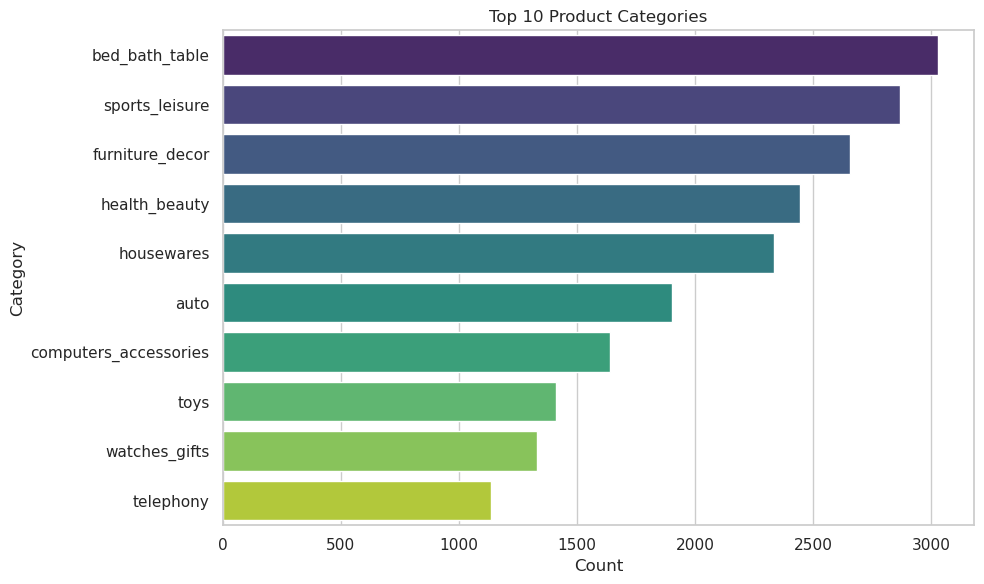

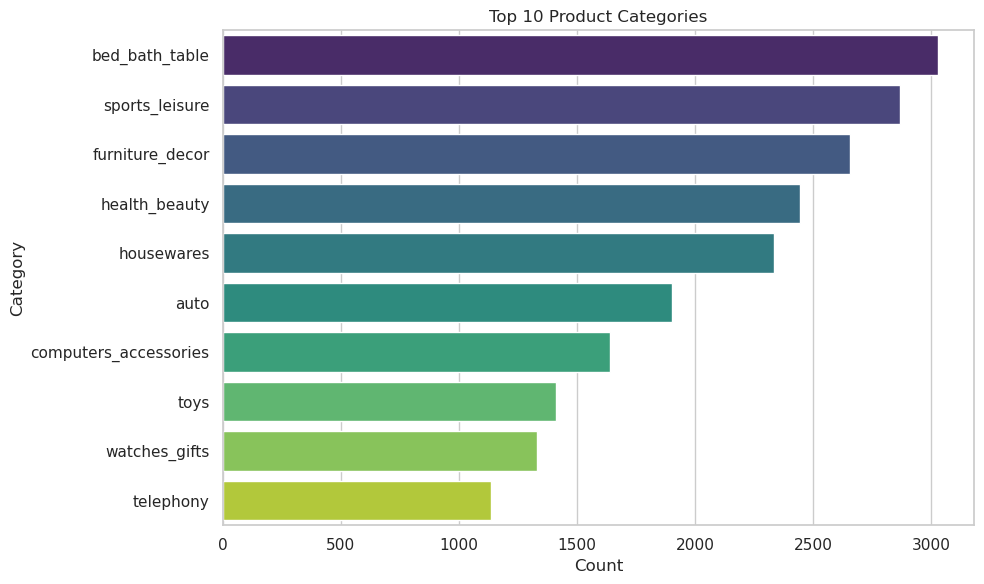

In [ ]:
# Compute category counts, save CSV and a top-10 bar plot
import pandas as pd
import matplotlib.pyplot as plt

p = db_dir / 'prod_name_english.csv'
df = pd.read_csv(p)

counts = (
    df['product_category_name_english']
    .value_counts()
    .reset_index()
)
counts.columns = ['product_category_name_english', 'count']
counts['percent'] = counts['count'] / counts['count'].sum()

out_csv = db_dir / 'prod_category_counts.csv'
counts.to_csv(out_csv, index=False)
print('Wrote', out_csv, 'with', len(counts), 'rows')

display(counts.head(20))

# Plot top 10 categories
# This is more about the variety of products for the product categories
top = counts.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(data=top, x='count', y='product_category_name_english', palette='viridis')
plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Top 10 Product Categories')
plt.tight_layout()
out_png = db_dir / 'prod_category_counts_top10.png'
plt.savefig(out_png)
print('Saved top-10 plot to', out_png)

display(plt.gcf())

In [10]:
# Create `purchase_time_citystate` table
# Merge orders and customers on customer_id to produce:
# order_id, customer_id, order_purchase_timestamp, customer_city, customer_state
# For unmatched customer info, fill with the string 'unmatched'.

order_candidates = sorted([p for p in db_dir.glob('*order*.csv')])
cust_candidates = sorted([p for p in db_dir.glob('*customer*.csv')])

print('order candidates:', [p.name for p in order_candidates])
print('customer candidates:', [p.name for p in cust_candidates])

if not order_candidates:
    raise FileNotFoundError(f'No order CSV found in {db_dir}')
if not cust_candidates:
    raise FileNotFoundError(f'No customer CSV found in {db_dir}')

# Prefer the orders file that contains a purchase timestamp column
selected_order = None
for p in order_candidates:
    try:
        hdr = pd.read_csv(p, nrows=0).columns.tolist()
        if 'order_purchase_timestamp' in hdr or any('purchase' in c.lower() for c in hdr):
            selected_order = p
            break
    except Exception:
        continue
if selected_order is None:
    selected_order = next((p for p in order_candidates if 'orders_dataset' in p.name), order_candidates[0])

order_path = selected_order
cust_path = cust_candidates[0]

print('Using order file:', order_path.name)
print('Using customer file:', cust_path.name)

orders = pd.read_csv(order_path, low_memory=False)
customers = pd.read_csv(cust_path, low_memory=False)

print('orders columns:', orders.columns.tolist())
print('customers columns:', customers.columns.tolist())

# Identify required columns
order_id_col = 'order_id' if 'order_id' in orders.columns else next((c for c in orders.columns if 'order' in c and 'id' in c), None)
order_purchase_col = 'order_purchase_timestamp' if 'order_purchase_timestamp' in orders.columns else next((c for c in orders.columns if 'purchase' in c.lower()), None)
customer_id_col = 'customer_id' if 'customer_id' in orders.columns else None

cust_id_col_2 = 'customer_id' if 'customer_id' in customers.columns else next((c for c in customers.columns if 'customer' in c and 'id' in c), None)
customer_city_col = next((c for c in customers.columns if 'city' in c.lower()), None)
customer_state_col = next((c for c in customers.columns if 'state' in c.lower()), None)

if not all([order_id_col, order_purchase_col, customer_id_col, cust_id_col_2, customer_city_col, customer_state_col]):
    raise ValueError(
        'Could not identify required columns automatically. '
        f'Found: order_id={order_id_col} order_purchase={order_purchase_col} customer_id_orders={customer_id_col} customer_id_customers={cust_id_col_2} city={customer_city_col} state={customer_state_col}'
    )

# Ensure consistent customer id column name for the join
orders = orders.rename(columns={customer_id_col: 'customer_id'})
customers = customers.rename(columns={cust_id_col_2: 'customer_id'})

# Normalize purchase timestamp column to a single name
orders = orders.rename(columns={order_purchase_col: 'order_purchase_timestamp'})

# Keep only needed columns
orders_sel = orders[['order_id', 'customer_id', 'order_purchase_timestamp']]
customers_sel = customers[['customer_id', customer_city_col, customer_state_col]].rename(columns={customer_city_col: 'customer_city', customer_state_col: 'customer_state'})

# Merge
merged = orders_sel.merge(customers_sel, on='customer_id', how='left')

# Fill unmatched customer info with the string 'unmatched'
merged['customer_city'] = merged['customer_city'].fillna('unmatched')
merged['customer_state'] = merged['customer_state'].fillna('unmatched')

# Save
out_path = db_dir / 'purchase_time_citystate.csv'
merged.to_csv(out_path, index=False)
print('Wrote', out_path, 'with shape', merged.shape)

# Show summary
display(merged.head())

total = len(merged)
unmatched_rows = (merged['customer_city'] == 'unmatched') | (merged['customer_state'] == 'unmatched')
num_unmatched = unmatched_rows.sum()
print(f'Total rows: {total}')
print(f'Rows with unmatched customer info: {num_unmatched} ({num_unmatched/total:.2%})')

# Show sample unmatched rows
if num_unmatched:
    print('\nSample unmatched rows:')
    display(merged[unmatched_rows].head())

order candidates: ['olist_order_items_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_orders_dataset.csv', 'olist_orders_dataset_clean.csv']
customer candidates: ['olist_customers_dataset.csv']
Using order file: olist_orders_dataset.csv
Using customer file: olist_customers_dataset.csv
orders columns: ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
customers columns: ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']
Wrote meltano-ingestion/db/purchase_time_citystate.csv with shape (99441, 5)


,order_id,customer_id,order_purchase_timestamp,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,santo andre,SP


Total rows: 99441
Rows with unmatched customer info: 0 (0.00%)


### Summary: Purchase time and location dataset

This section summarizes the `purchase_time_citystate` dataset and saves aggregation outputs and plots:

- `meltano-ingestion/db/purchase_time_citystate.csv` — merged orders+customers (already created)
- `meltano-ingestion/db/orders_by_month_state_top_states.csv` — monthly orders for top states
- `meltano-ingestion/db/orders_over_time_top_states.png` — time series plot for top states
- `meltano-ingestion/db/top_cities.csv` — top cities by order count
- `meltano-ingestion/db/top_cities_top20.png` — bar chart of top 20 cities

All saved files are stored under `meltano-ingestion/db/` for reproducibility.

Top states: ['SP', 'RJ', 'MG', 'RS', 'PR', 'SC', 'BA', 'DF']


/tmp/ipykernel_46857/2538407267.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), 'customer_state'])


Saved time-series plot to meltano-ingestion/db/orders_over_time_top_states.png


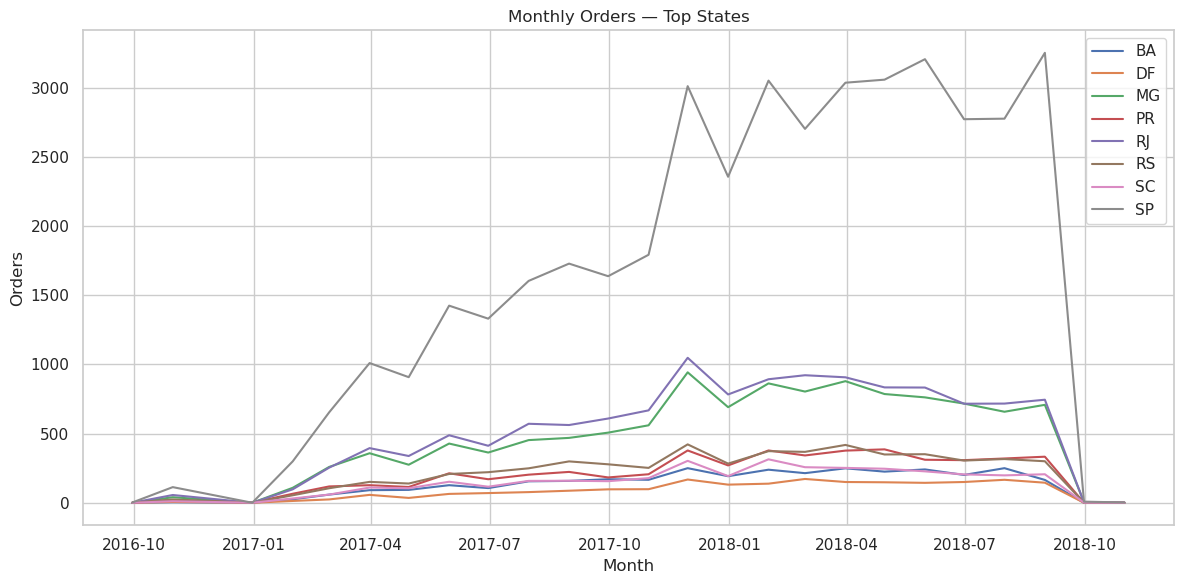

/tmp/ipykernel_46857/2538407267.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top20, x='count', y='customer_city', palette='magma')


Saved top-20 cities plot to meltano-ingestion/db/top_cities_top20.png


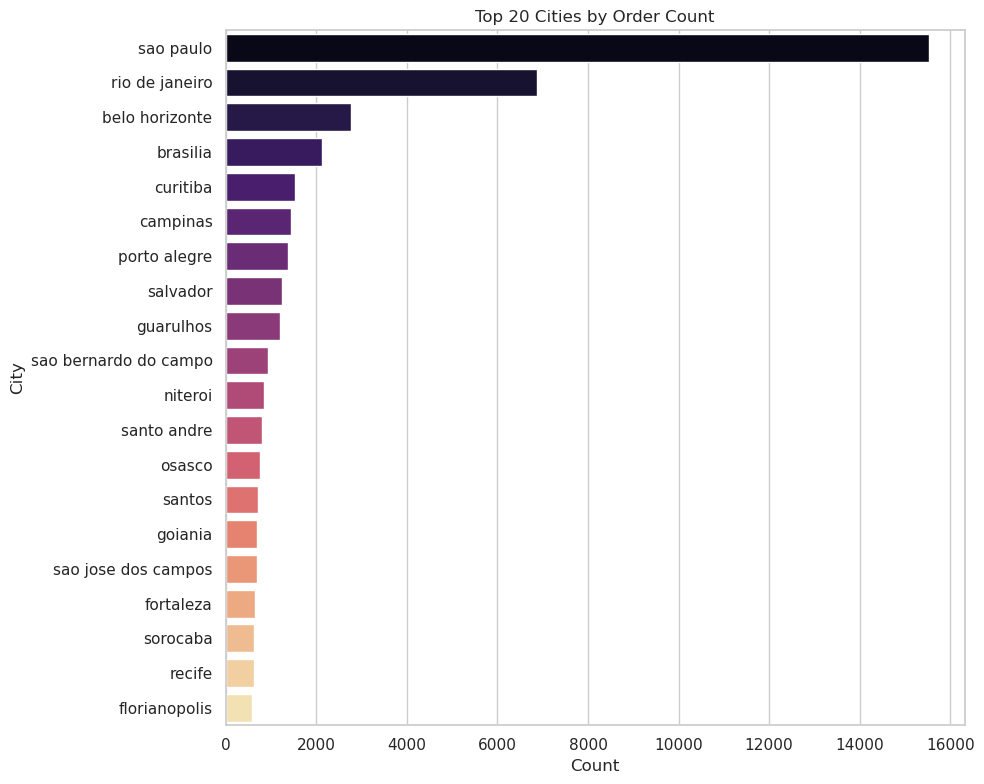


Sample top states counts:


,customer_state,count
0,SP,41746
1,RJ,12852
2,MG,11635
3,RS,5466
4,PR,5045



Sample top cities:


,customer_city,count
0,sao paulo,15540
1,rio de janeiro,6882
2,belo horizonte,2773
3,brasilia,2131
4,curitiba,1521
5,campinas,1444
6,porto alegre,1379
7,salvador,1245
8,guarulhos,1189
9,sao bernardo do campo,938


In [11]:
# Aggregations and plots: orders over time by state and top cities
import pandas as pd
import matplotlib.pyplot as plt

p = db_dir / 'purchase_time_citystate.csv'
df = pd.read_csv(p)

# Ensure timestamp is datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], errors='coerce')

# Top states by total orders
state_counts = df['customer_state'].value_counts().reset_index()
state_counts.columns = ['customer_state', 'count']
state_counts.to_csv(db_dir / 'orders_by_state_total.csv', index=False)

top_states = state_counts['customer_state'].head(8).tolist()
print('Top states:', top_states)

# Orders by month for top states
df_month = (
    df[df['customer_state'].isin(top_states)]
    .set_index('order_purchase_timestamp')
    .groupby([pd.Grouper(freq='M'), 'customer_state'])
    .size()
    .reset_index(name='orders')
)

# Pivot for plotting
pivot = df_month.pivot(index='order_purchase_timestamp', columns='customer_state', values='orders').fillna(0)
pivot.to_csv(db_dir / 'orders_by_month_state_top_states.csv')

# Plot time series for top states
plt.figure(figsize=(12, 6))
for state in pivot.columns:
    plt.plot(pivot.index, pivot[state], label=state)
plt.legend()
plt.xlabel('Month')
plt.ylabel('Orders')
plt.title('Monthly Orders — Top States')
plt.tight_layout()
out_ts = db_dir / 'orders_over_time_top_states.png'
plt.savefig(out_ts)
print('Saved time-series plot to', out_ts)
display(plt.gcf())
plt.close()

# Top cities by order count (top 20)
city_counts = df['customer_city'].value_counts().reset_index()
city_counts.columns = ['customer_city', 'count']
city_counts.to_csv(db_dir / 'top_cities.csv', index=False)

top20 = city_counts.head(20)
plt.figure(figsize=(10, 8))
sns.barplot(data=top20, x='count', y='customer_city', palette='magma')
plt.xlabel('Count')
plt.ylabel('City')
plt.title('Top 20 Cities by Order Count')
plt.tight_layout()
out_cities = db_dir / 'top_cities_top20.png'
plt.savefig(out_cities)
print('Saved top-20 cities plot to', out_cities)

display(plt.gcf())
plt.close()

# Show short samples
print('\nSample top states counts:')
display(state_counts.head())
print('\nSample top cities:')
display(top20)

In [13]:
# Create `order_prod_price_name` table
# Merge order items with product category names (English)
# Columns: order_id, product_id, price, product_category_name_english

order_items_candidates = sorted([p for p in db_dir.glob('*order_items*.csv')])
prod_name_path = db_dir / 'prod_name_english.csv'

print('order_items candidates:', [p.name for p in order_items_candidates])
print('prod_name file:', prod_name_path.name)

if not order_items_candidates:
    raise FileNotFoundError(f'No order_items CSV found in {db_dir}')
if not prod_name_path.exists():
    raise FileNotFoundError(f'No prod_name_english.csv found in {db_dir}; run the product merge step first')

order_items_path = order_items_candidates[0]

order_items = pd.read_csv(order_items_path, low_memory=False)
prod_names = pd.read_csv(prod_name_path, low_memory=False)

print('order_items columns:', order_items.columns.tolist())
print('prod_names columns:', prod_names.columns.tolist())

# Ensure required columns exist
required = ['order_id', 'product_id', 'price']
for c in required:
    if c not in order_items.columns:
        raise ValueError(f'Missing required column in order items: {c}')
if 'product_category_name_english' not in prod_names.columns:
    raise ValueError('Expected column product_category_name_english in prod_name_english.csv')

# Merge
merged = order_items.merge(prod_names, on='product_id', how='left')

# Fill missing product category names with string 'null'
merged['product_category_name_english'] = merged['product_category_name_english'].fillna('null')

result = merged[['order_id', 'product_id', 'price', 'product_category_name_english']]

out_path = db_dir / 'order_prod_price_name.csv'
result.to_csv(out_path, index=False)
print('Wrote', out_path, 'with shape', result.shape)

# Summary
total = len(result)
null_count = (result['product_category_name_english'] == 'null').sum()
print(f'Total rows: {total}')
print(f"Rows with 'null' product_category_name_english: {null_count} ({null_count/total:.2%})")

display(result.head())

order_items candidates: ['olist_order_items_dataset.csv']
prod_name file: prod_name_english.csv
order_items columns: ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
prod_names columns: ['product_id', 'product_category_name_english']
Wrote meltano-ingestion/db/order_prod_price_name.csv with shape (112650, 4)
Total rows: 112650
Rows with 'null' product_category_name_english: 1627 (1.44%)


,order_id,product_id,price,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.90,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,239.90,pet_shop
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,199.00,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,12.99,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,199.90,garden_tools


In [18]:
# Analysis: find max price among rows with product_category_name_english == 'null'
import pandas as pd
p = db_dir / 'order_prod_price_name.csv'
df = pd.read_csv(p)
# Ensure numeric
df['price'] = pd.to_numeric(df['price'], errors='coerce')
null_df = df[df['product_category_name_english'] == 'null']
max_price = null_df['price'].max()
print('Rows with null category:', len(null_df))
print('Max price among null-category rows:', max_price)
# Show product_id(s) and order_id(s) with that price
matches = null_df[null_df['price'] == max_price][['product_id', 'order_id', 'price']].drop_duplicates()
display(matches)


Rows with null category: 0
Max price among null-category rows: nan


,product_id,order_id,price


In [20]:
# Check for missing or non-numeric price values in order_prod_price_name.csv
import pandas as pd
p = db_dir / 'order_prod_price_name.csv'
df = pd.read_csv(p)

# Convert to numeric (coerce errors to NaN)
price_num = pd.to_numeric(df['price'], errors='coerce')
num_missing = price_num.isna().sum()
total = len(df)
print(f"Total rows: {total}")
print(f"Missing or non-numeric 'price': {num_missing} ({num_missing/total:.2%})")

if num_missing:
    print('\nSample rows with missing/non-numeric price:')
    display(df[price_num.isna()].head())

Total rows: 112650
Missing or non-numeric 'price': 0 (0.00%)


In [21]:
# Check for null or empty product_id in order_prod_price_name.csv
import pandas as pd
p = db_dir / 'order_prod_price_name.csv'
df = pd.read_csv(p, dtype=str)

# Consider both NaN and empty/whitespace-only strings as missing
null_mask = df['product_id'].isna() | (df['product_id'].str.strip() == '')
num_nulls = null_mask.sum()
total = len(df)
print(f"Total rows: {total}")
print(f"Null or empty product_id: {num_nulls} ({num_nulls/total:.2%})")

if num_nulls:
    print('\nSample rows with null/empty product_id:')
    display(df[null_mask].head())

Total rows: 112650
Null or empty product_id: 0 (0.00%)


In [22]:
# Check for null or empty order_id in order_prod_price_name.csv
import pandas as pd
p = db_dir / 'order_prod_price_name.csv'
df = pd.read_csv(p, dtype=str)

# Consider both NaN and empty/whitespace-only strings as missing
null_mask = df['order_id'].isna() | (df['order_id'].str.strip() == '')
num_nulls = null_mask.sum()
total = len(df)
print(f"Total rows: {total}")
print(f"Null or empty order_id: {num_nulls} ({num_nulls/total:.2%})")

if num_nulls:
    print('\nSample rows with null/empty order_id:')
    display(df[null_mask].head())

Total rows: 112650
Null or empty order_id: 0 (0.00%)


In [23]:
# Create `order_prod_time_price_citystate` table
# Merge order-product-price with purchase time & customer location on order_id

items_p = db_dir / 'order_prod_price_name.csv'
time_p = db_dir / 'purchase_time_citystate.csv'

print('Files:', items_p.name, time_p.name)

items = pd.read_csv(items_p, low_memory=False)
time = pd.read_csv(time_p, low_memory=False)

print('items columns:', items.columns.tolist())
print('time columns:', time.columns.tolist())

# Merge on order_id (left join to keep all order items)
merged = items.merge(time[['order_id', 'order_purchase_timestamp', 'customer_city', 'customer_state']], on='order_id', how='left')

# For unmatched pairs (i.e., NaN from the join), fill with 'unmatched'
for col in ['order_purchase_timestamp', 'customer_city', 'customer_state']:
    merged[col] = merged[col].fillna('unmatched')

# Save
out_path = db_dir / 'order_prod_time_price_citystate.csv'
merged.to_csv(out_path, index=False)
print('Wrote', out_path, 'with shape', merged.shape)

# Summaries
total = len(merged)
num_unmatched = ((merged['order_purchase_timestamp'] == 'unmatched') | (merged['customer_city'] == 'unmatched') | (merged['customer_state'] == 'unmatched')).sum()
print(f'Total rows: {total}')
print(f'Rows with unmatched purchase/time/location info: {num_unmatched} ({num_unmatched/total:.2%})')

# Show sample unmatched rows and head
if num_unmatched:
    print('\nSample rows with unmatched info:')
    display(merged[ (merged['order_purchase_timestamp'] == 'unmatched') | (merged['customer_city'] == 'unmatched') | (merged['customer_state'] == 'unmatched') ].head())

print('\nHead of merged table:')
display(merged.head())

Files: order_prod_price_name.csv purchase_time_citystate.csv
items columns: ['order_id', 'product_id', 'price', 'product_category_name_english']
time columns: ['order_id', 'customer_id', 'order_purchase_timestamp', 'customer_city', 'customer_state']
Wrote meltano-ingestion/db/order_prod_time_price_citystate.csv with shape (112650, 7)
Total rows: 112650
Rows with unmatched purchase/time/location info: 0 (0.00%)

Head of merged table:


,order_id,product_id,price,product_category_name_english,order_purchase_timestamp,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.90,cool_stuff,2017-09-13 08:59:02,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,239.90,pet_shop,2017-04-26 10:53:06,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,199.00,furniture_decor,2018-01-14 14:33:31,para de minas,MG
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,12.99,perfumery,2018-08-08 10:00:35,atibaia,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,199.90,garden_tools,2017-02-04 13:57:51,varzea paulista,SP


In [24]:
# Extract purchase date and time columns from order_purchase_timestamp
# Insert `order_purchase_date` and `order_purchase_time` right after `order_purchase_timestamp`.

p = db_dir / 'order_prod_time_price_citystate.csv'
df = pd.read_csv(p, low_memory=False)

# Preserve the raw string to detect earlier 'unmatched' values
ts_raw = df['order_purchase_timestamp'].astype(str)
# Parse timestamps (coerce errors to NaT)
ts = pd.to_datetime(df['order_purchase_timestamp'], errors='coerce')

# Create formatted date/time columns
df['order_purchase_date'] = ts.dt.strftime('%Y-%m-%d')
df['order_purchase_time'] = ts.dt.strftime('%H:%M:%S')

# For rows where parsing failed or original was 'unmatched', set both to 'unmatched'
mask_unmatched = ts.isna() | (ts_raw.str.lower() == 'unmatched')
if mask_unmatched.any():
    df.loc[mask_unmatched, 'order_purchase_date'] = 'unmatched'
    df.loc[mask_unmatched, 'order_purchase_time'] = 'unmatched'

# Reorder columns to place the new columns immediately after order_purchase_timestamp
cols = df.columns.tolist()
try:
    idx = cols.index('order_purchase_timestamp') + 1
except ValueError:
    idx = len(cols)
# ensure the new columns are placed after the timestamp
cols = [c for c in cols if c not in ('order_purchase_date', 'order_purchase_time')]
new_cols = cols[:idx] + ['order_purchase_date', 'order_purchase_time'] + cols[idx:]
# Reindex DataFrame with new column order
df = df.reindex(columns=new_cols)

# Save updated CSV
df.to_csv(p, index=False)
print('Updated', p.name, '— shape:', df.shape)

# Summary
num_unmatched = mask_unmatched.sum()
print(f'Rows with unmatched timestamps: {num_unmatched} ({num_unmatched/len(df):.2%})')

# Show head
display(df.head())

Updated order_prod_time_price_citystate.csv — shape: (112650, 9)
Rows with unmatched timestamps: 0 (0.00%)


,order_id,product_id,price,product_category_name_english,order_purchase_timestamp,order_purchase_date,order_purchase_time,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.90,cool_stuff,2017-09-13 08:59:02,2017-09-13,08:59:02,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,239.90,pet_shop,2017-04-26 10:53:06,2017-04-26,10:53:06,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,199.00,furniture_decor,2018-01-14 14:33:31,2018-01-14,14:33:31,para de minas,MG
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,12.99,perfumery,2018-08-08 10:00:35,2018-08-08,10:00:35,atibaia,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,199.90,garden_tools,2017-02-04 13:57:51,2017-02-04,13:57:51,varzea paulista,SP


In [27]:
# Add `day_of_week` derived from `order_purchase_date` and `time_of_day` from `order_purchase_time`
# Note: 00:00-00:59 is assigned to 'Wee' to resolve the overlap with 'Eveng'.
import numpy as np

p = db_dir / 'order_prod_time_price_citystate.csv'
df = pd.read_csv(p, low_memory=False)

# Day of week
mask_unmatched = df['order_purchase_date'].isna() | (df['order_purchase_date'].astype(str).str.lower() == 'unmatched')
dates = pd.to_datetime(df['order_purchase_date'], errors='coerce')

df['day_of_week'] = dates.dt.day_name()
df.loc[mask_unmatched, 'day_of_week'] = 'unmatched'

# Time of day labels based on order_purchase_time
# Ranges (inclusive):
#  - Morn: 05:00 - 11:59
#  - Lunch: 12:00 - 13:59
#  - Aftern: 14:00 - 16:59
#  - OffWk: 17:00 - 18:59
#  - Eveng: 19:00 - 23:59 (19:00 - 00:59 in original spec; we treat 00:00-00:59 as 'Wee')
#  - Wee: 00:00 - 04:59

# Parse hour from order_purchase_time; errors -> NaN
hours = pd.to_datetime(df['order_purchase_time'], format='%H:%M:%S', errors='coerce').dt.hour

conditions = [
    hours.between(5, 11),   # Morn
    hours.between(12, 13),  # Lunch
    hours.between(14, 16),  # Aftern
    hours.between(17, 18),  # OffWk
    hours.between(19, 23),  # Eveng (19:00-23:59)
    hours.between(0, 4)     # Wee (00:00-04:59)
]
choices = ['Morn', 'Lunch', 'Aftern', 'OffWk', 'Eveng', 'Wee']

df['time_of_day'] = np.select(conditions, choices, default='unmatched')

# For any rows where the original string was 'unmatched', ensure label is 'unmatched'
mask_time_unmatched = df['order_purchase_time'].astype(str).str.lower() == 'unmatched'
df.loc[mask_time_unmatched, 'time_of_day'] = 'unmatched'

# Reorder columns: place day_of_week and time_of_day right after order_purchase_date
cols = df.columns.tolist()
if 'order_purchase_date' in cols:
    idx = cols.index('order_purchase_date') + 1
else:
    idx = len(cols)
cols = [c for c in cols if c not in ('day_of_week', 'time_of_day')]
new_cols = cols[:idx] + ['day_of_week', 'time_of_day'] + cols[idx:]

# Reindex and save
df = df.reindex(columns=new_cols)
df.to_csv(p, index=False)
print('Updated', p.name, '— shape:', df.shape)

num_unmatched_day = (df['day_of_week'] == 'unmatched').sum()
num_unmatched_time = (df['time_of_day'] == 'unmatched').sum()
print(f"Rows with 'unmatched' day_of_week: {num_unmatched_day} ({num_unmatched_day/len(df):.2%})")
print(f"Rows with 'unmatched' time_of_day: {num_unmatched_time} ({num_unmatched_time/len(df):.2%})")

print('\nCounts by time_of_day:')
print(df['time_of_day'].value_counts(dropna=False))

# Show samples
display(df[['order_purchase_time', 'time_of_day']].head())

Updated order_prod_time_price_citystate.csv — shape: (112650, 11)
Rows with 'unmatched' day_of_week: 0 (0.00%)
Rows with 'unmatched' time_of_day: 0 (0.00%)

Counts by time_of_day:
time_of_day
Eveng     31689
Morn      25443
Aftern    22588
Lunch     14222
OffWk     13560
Wee        5148
Name: count, dtype: int64


,order_purchase_time,time_of_day
0,08:59:02,Morn
1,10:53:06,Morn
2,14:33:31,Aftern
3,10:00:35,Morn
4,13:57:51,Lunch


In [26]:
display(df.head())

,order_id,product_id,price,product_category_name_english,order_purchase_timestamp,order_purchase_date,day_of_week,order_purchase_time,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.90,cool_stuff,2017-09-13 08:59:02,2017-09-13,Wednesday,08:59:02,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,239.90,pet_shop,2017-04-26 10:53:06,2017-04-26,Wednesday,10:53:06,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,199.00,furniture_decor,2018-01-14 14:33:31,2018-01-14,Sunday,14:33:31,para de minas,MG
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,12.99,perfumery,2018-08-08 10:00:35,2018-08-08,Wednesday,10:00:35,atibaia,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,199.90,garden_tools,2017-02-04 13:57:51,2017-02-04,Saturday,13:57:51,varzea paulista,SP
